In [33]:
import time
from torch import Tensor
from typing import List, Literal, Tuple
import numpy as np
from typing import Dict, Optional, Union
import logging
from sentence_transformers import quantize_embeddings
import pickle
import matplotlib.pyplot as plt
import matplotlib

from time import perf_counter

logger = logging.getLogger(__name__)

In [31]:
# Code from SentenceTransformers quantization.py
def semantic_search_usearch(
    query_embeddings: np.ndarray,
    corpus_embeddings: Optional[np.ndarray] = None,
    corpus_index: Optional["usearch.index.Index"] = None,
    corpus_precision: Literal["float32", "int8", "binary"] = "float32",
    top_k: int = 10,
    ranges: Optional[np.ndarray] = None,
    calibration_embeddings: Optional[np.ndarray] = None,
    rescore: bool = True,
    rescore_multiplier: int = 2,
    exact: bool = True,
    output_index: bool = False,
) -> Tuple[List[List[Dict[str, Union[int, float]]]], float, "usearch.index.Index"]:
    """
    Performs semantic search using the usearch library.

    Rescoring will be performed if:
    1. `rescore` is True
    2. The query embeddings are not quantized
    3. The corpus is quantized, i.e. the corpus precision is not float32
    Only if these conditions are true, will we search for `top_k * rescore_multiplier` samples and then rescore to only
    keep `top_k`.

    :param query_embeddings: Embeddings of the query sentences. Ideally not quantized to allow for rescoring.
    :param corpus_embeddings: Embeddings of the corpus sentences. Either `corpus_embeddings` or `corpus_index` should
        be used, not both. The embeddings can be quantized to "int8" or "binary" for more efficient search.
    :param corpus_index: usearch index for the corpus sentences. Either `corpus_embeddings` or `corpus_index` should
        be used, not both.
    :param corpus_precision: Precision of the corpus embeddings. The options are "float32", "int8", or "binary".
        Default is "float32".
    :param top_k: Number of top results to retrieve. Default is 10.
    :param ranges: Ranges for quantization of embeddings. This is only used for int8 quantization, where the ranges
        refers to the minimum and maximum values for each dimension. So, it's a 2D array with shape (2, embedding_dim).
        Default is None, which means that the ranges will be calculated from the calibration embeddings.
    :param calibration_embeddings: Embeddings used for calibration during quantization. This is only used for int8
        quantization, where the calibration embeddings can be used to compute ranges, i.e. the minimum and maximum
        values for each dimension. Default is None, which means that the ranges will be calculated from the query
        embeddings. This is not recommended.
    :param rescore: Whether to perform rescoring. Note that rescoring still will only be used if the query embeddings
        are not quantized and the corpus is quantized, i.e. the corpus precision is not "float32". Default is True.
    :param rescore_multiplier: Oversampling factor for rescoring. The code will now search `top_k * rescore_multiplier` samples
        and then rescore to only keep `top_k`. Default is 2.
    :param exact: Whether to use exact search or approximate search. Default is True.
    :param output_index: Whether to output the usearch index used for the search. Default is False.

    :return: A tuple containing a list of search results and the time taken for the search. If `output_index` is True,
        the tuple will also contain the usearch index used for the search.
    :raises ValueError: If both `corpus_embeddings` and `corpus_index` are provided or if neither is provided.

    The list of search results is in the format: [[{"corpus_id": int, "score": float}, ...], ...]
    The time taken for the search is a float value.
    """
    from usearch.index import Index
    from usearch.compiled import ScalarKind

    if corpus_embeddings is not None and corpus_index is not None:
        raise ValueError("Only corpus_embeddings or corpus_index should be used, not both.")
    if corpus_embeddings is None and corpus_index is None:
        raise ValueError("Either corpus_embeddings or corpus_index should be used.")
    if corpus_precision not in ["float32", "int8", "binary"]:
        raise ValueError('corpus_precision must be "float32", "int8", or "binary" for usearch')

    # If corpus_index is not provided, create a new index
    if corpus_index is None:
        if corpus_precision == "float32":
            corpus_index = Index(
                ndim=corpus_embeddings.shape[1],
                metric="cos",
                dtype="f32",
            )
        elif corpus_precision == "int8":
            corpus_index = Index(
                ndim=corpus_embeddings.shape[1],
                metric="ip",
                dtype="i8",
            )
        elif corpus_precision == "binary":
            corpus_index = Index(
                ndim=corpus_embeddings.shape[1],
                metric="hamming",
                dtype="i8",
            )
        corpus_index.add(np.arange(len(corpus_embeddings)), corpus_embeddings)

    # If rescoring is enabled and the query embeddings are in float32, we need to quantize them
    # to the same precision as the corpus embeddings. Also update the top_k value to account for the
    # rescore_multiplier
    rescore_embeddings = None
    k = top_k
    if query_embeddings.dtype not in (np.uint8, np.int8):
        if rescore:
            if corpus_index.dtype != ScalarKind.F32:
                rescore_embeddings = query_embeddings
                k *= rescore_multiplier
            else:
                logger.warning(
                    "Rescoring is enabled but the corpus is not quantized. Either pass `rescore=False` or "
                    'quantize the corpus embeddings with `quantize_embeddings(embeddings, precision="...") `'
                    'and pass `corpus_precision="..."` to `semantic_search_usearch`.'
                )

        query_embeddings = quantize_embeddings(
            query_embeddings,
            precision=corpus_precision,
            ranges=ranges,
            calibration_embeddings=calibration_embeddings,
        )
    elif rescore:
        logger.warning(
            "Rescoring is enabled but the query embeddings are quantized. Either pass `rescore=False` or don't quantize the query embeddings."
        )

    # Perform the search using the usearch index
    start_t = time.time()
    matches = corpus_index.search(query_embeddings, count=k, exact=exact)
    scores = matches.distances
    indices = matches.keys

    if scores.ndim < 2:
        scores = np.atleast_2d(scores)
    if indices.ndim < 2:
        indices = np.atleast_2d(indices)

    # If rescoring is enabled, we need to rescore the results using the rescore_embeddings
    if rescore_embeddings is not None:
        top_k_embeddings = np.array([corpus_index.get(query_indices) for query_indices in indices])
        # If the corpus precision is binary, we need to unpack the bits
        if corpus_precision == "binary":
            top_k_embeddings = np.unpackbits(top_k_embeddings.astype(np.uint8), axis=-1)
        top_k_embeddings = top_k_embeddings.astype(int)

        # rescore_embeddings: [num_queries, embedding_dim]
        # top_k_embeddings: [num_queries, top_k, embedding_dim]
        # updated_scores: [num_queries, top_k]
        # We use einsum to calculate the dot product between the query and the top_k embeddings, equivalent to looping
        # over the queries and calculating 'rescore_embeddings[i] @ top_k_embeddings[i].T'
        rescored_scores = np.einsum("ij,ikj->ik", rescore_embeddings, top_k_embeddings)
        rescored_indices = np.argsort(-rescored_scores)[:, :top_k]
        indices = indices[np.arange(len(query_embeddings))[:, None], rescored_indices]
        scores = rescored_scores[np.arange(len(query_embeddings))[:, None], rescored_indices]

    delta_t = time.time() - start_t

    outputs = (
        [
            [
                {"corpus_id": int(neighbor), "score": float(score)}
                for score, neighbor in zip(scores[query_id], indices[query_id])
            ]
            for query_id in range(len(query_embeddings))
        ],
        delta_t,
    )
    if output_index:
        outputs = (*outputs, corpus_index)
    return outputs

In [55]:
# Say the model produces (300, 768) for queries embeddings, (5183, 768) for document embeddings
query_embeddings_og = np.random.rand(300, 768).astype(np.float32)
doc_embeddings_og = np.random.rand(5183, 768).astype(np.float32)

N = 50

matryoshka_truncation = [768, 512, 256, 128, 64]

In [56]:
profiling_results = dict()

### Evaluation
We evaluate across f32, int8, bianry; each for matryoshka truncation 768 to 3

In [57]:
def evaluate(precision):
    query_embeddings = None
    doc_embeddings = None

    # 1. Quantize
    if precision == "float32":
        query_embeddings = query_embeddings_og
        doc_embeddings = doc_embeddings_og
    elif precision == "int8":
        query_embeddings = quantize_embeddings(query_embeddings_og, "int8")
        doc_embeddings = quantize_embeddings(query_embeddings_og, "int8")
    elif precision == "binary":
        query_embeddings = quantize_embeddings(query_embeddings_og, "binary")
        doc_embeddings = quantize_embeddings(query_embeddings_og, "binary")

    # 2. Evaluate
    cur_results = dict()
    for trunc in matryoshka_truncation:
        t_start = perf_counter() 
        for i in range(N):
            semantic_search_usearch(
                query_embeddings[:, :trunc],
                doc_embeddings[:, :trunc],
                corpus_precision=precision,
                rescore=False
            )
        t_end = perf_counter()

        avg_time = (t_end - t_start) / N
        cur_results[trunc] = avg_time
        print(f"Precision {precision}, trunc {trunc}: {avg_time} sec")

    profiling_results[precision] = cur_results

In [58]:
evaluate("float32")

Precision float32, trunc 768: 0.4223675366491079 sec
Precision float32, trunc 512: 0.31070906419306993 sec
Precision float32, trunc 256: 0.22387130916118622 sec
Precision float32, trunc 128: 0.22348077416419984 sec
Precision float32, trunc 64: 0.23647553665563464 sec


In [59]:
evaluate("int8")

Precision int8, trunc 768: 0.015176305007189512 sec
Precision int8, trunc 512: 0.014405191652476787 sec
Precision int8, trunc 256: 0.01417341833934188 sec
Precision int8, trunc 128: 0.01408778915181756 sec
Precision int8, trunc 64: 0.014437007512897252 sec


In [60]:
evaluate("binary")

Precision binary, trunc 768: 0.015259345844388008 sec
Precision binary, trunc 512: 0.016020098347216846 sec
Precision binary, trunc 256: 0.015889465007930995 sec
Precision binary, trunc 128: 0.015326855834573508 sec
Precision binary, trunc 64: 0.015282084997743368 sec


In [61]:
profiling_results

{'float32': {768: 0.4223675366491079,
  512: 0.31070906419306993,
  256: 0.22387130916118622,
  128: 0.22348077416419984,
  64: 0.23647553665563464},
 'int8': {768: 0.015176305007189512,
  512: 0.014405191652476787,
  256: 0.01417341833934188,
  128: 0.01408778915181756,
  64: 0.014437007512897252},
 'binary': {768: 0.015259345844388008,
  512: 0.016020098347216846,
  256: 0.015889465007930995,
  128: 0.015326855834573508,
  64: 0.015282084997743368}}

In [65]:
# with open('latency_eval.pkl', 'wb') as handle:
#     pickle.dump(profiling_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [3]:
with open('latency_eval.pkl', 'rb') as handle:
    profiling_results = pickle.load(handle)

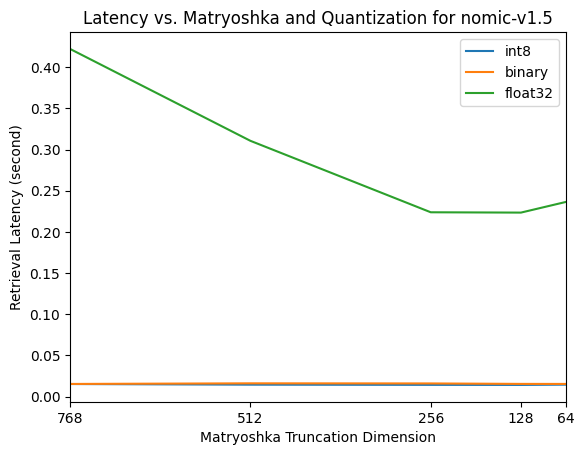

In [32]:
dims = [768, 512, 256, 128, 64]

for precision in ["int8", "binary", "float32"]:
    cur_results = profiling_results[precision]
    secs = []
    for dim in dims:
        secs.append(cur_results[dim])
    plt.plot(dims, secs, label = f"{precision}")

plt.xticks(dims)
plt.legend()
plt.xlim(768, 64)
plt.xlabel("Matryoshka Truncation Dimension")
plt.ylabel("Retrieval Latency (second)")
plt.title("Latency vs. Matryoshka and Quantization for nomic-v1.5")
plt.savefig("latency_3.png", dpi=300)

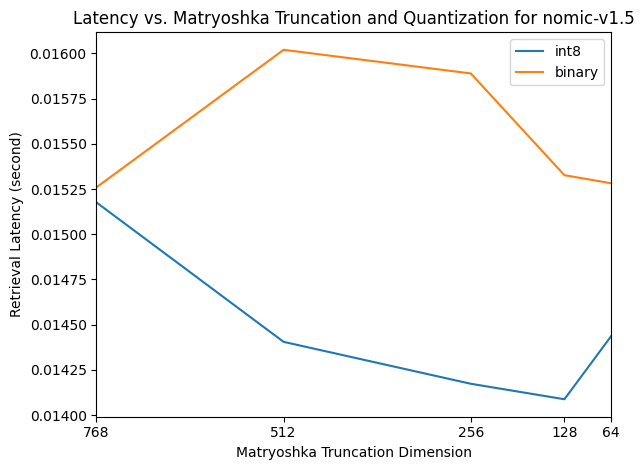

In [31]:
dims = [768, 512, 256, 128, 64]

for precision in ["int8", "binary"]:
    cur_results = profiling_results[precision]
    secs = []
    for dim in dims:
        secs.append(cur_results[dim])
    plt.plot(dims, secs, label = f"{precision}")

plt.xticks(dims)
plt.legend()
plt.xlim(768, 64)
plt.xlabel("Matryoshka Truncation Dimension")
plt.ylabel("Retrieval Latency (second)")
plt.title("Latency vs. Matryoshka Truncation and Quantization for nomic-v1.5");
plt.tight_layout()
plt.savefig("latency_2.png", dpi=300)

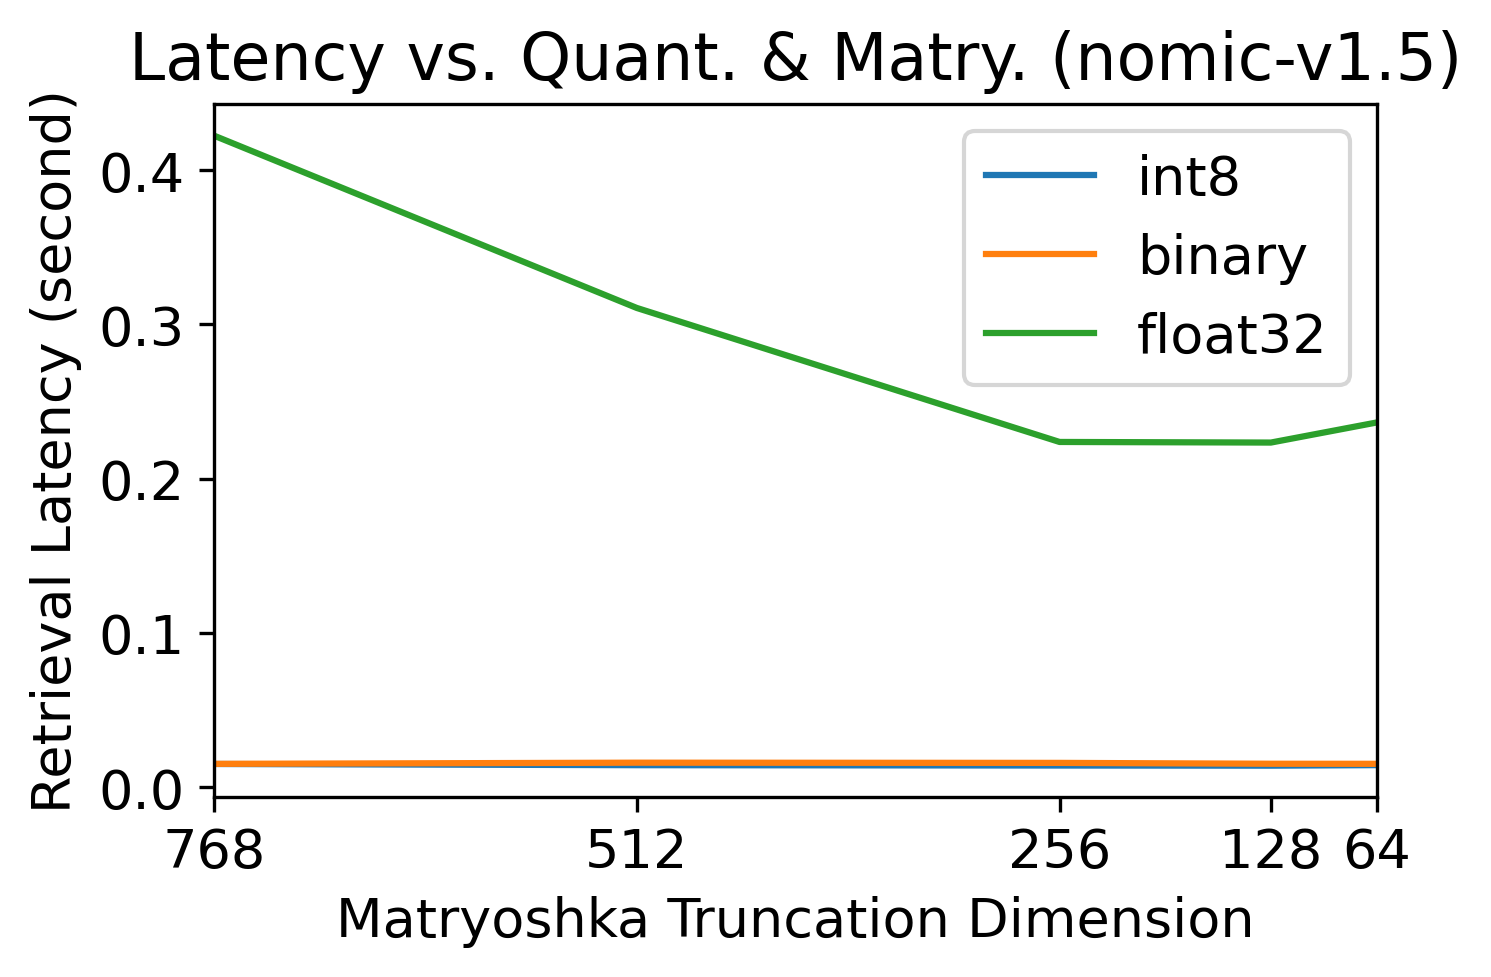

In [37]:
dims = [768, 512, 256, 128, 64]
matplotlib.rcParams.update({'font.size': 13})

plt.figure(figsize=(5,3), dpi=300)

for precision in ["int8", "binary", "float32"]:
    cur_results = profiling_results[precision]
    secs = []
    for dim in dims:
        secs.append(cur_results[dim])
    plt.plot(dims, secs, label = f"{precision}")

plt.xticks(dims)
plt.legend()
plt.xlim(768, 64)
plt.xlabel("Matryoshka Truncation Dimension")
plt.ylabel("Retrieval Latency (second)")
plt.title("Latency vs. Quant. & Matry. (nomic-v1.5)")
plt.savefig("latency_3_poster.png", dpi=300)

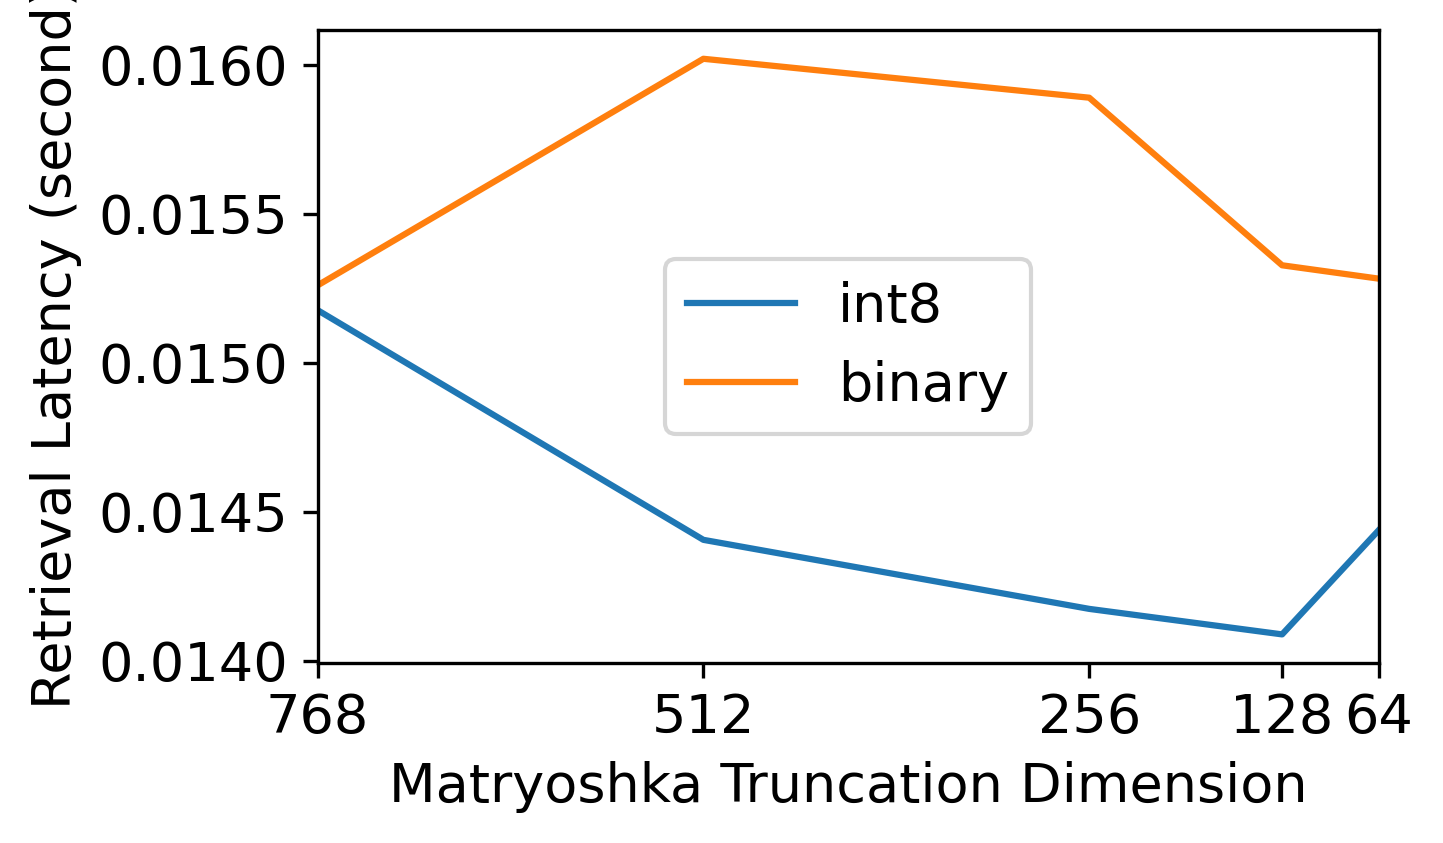

In [39]:
dims = [768, 512, 256, 128, 64]
matplotlib.rcParams.update({'font.size': 13})

plt.figure(figsize=(5,3), dpi=300)

for precision in ["int8", "binary"]:
    cur_results = profiling_results[precision]
    secs = []
    for dim in dims:
        secs.append(cur_results[dim])
    plt.plot(dims, secs, label = f"{precision}")

plt.xticks(dims)
plt.legend()
plt.xlim(768, 64)
plt.xlabel("Matryoshka Truncation Dimension")
plt.ylabel("Retrieval Latency (second)")
plt.tight_layout()
plt.savefig("latency_2_poster.png", dpi=300)